In [9]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# #from Fun.adf_test import adf_test
# from causation_test import causation_test

import statsmodels
#from adf_test import adf_test ## Error mulu kalau mau pake relative

In [21]:
### FUNCTION 
from statsmodels.tsa.stattools import adfuller
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    # H0 : Data isnt stationary
    # H1 : Data is stationary

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")


from statsmodels.tsa.stattools import grangercausalitytests

def causation_test(data, variables, test='ssr_chi2test', verbose=False,maxlag=12):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

from statsmodels.tsa.api import VAR

def vector_ar(p,data):
    model = VAR(data)
    for p in range(1,p+1):
        result = model.fit(p)
        print(f"p : {p} and AIC : {result.aic}")
        print('==='*11)

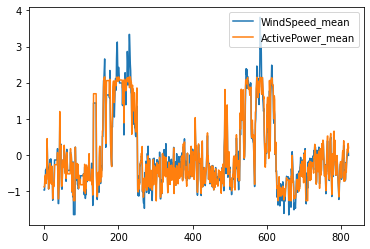

In [11]:
data = pd.read_csv('/Users/abilfad/Desktop/legit/technical_test/code/iter1/data_update_1.csv')
((data.iloc[:,1:]-data.iloc[:,1:].mean())/data.iloc[:,1:].std()).plot()


### data 1
data_1 = data.copy()
data_1.set_index(['time'], inplace=True)


In [12]:
data_1

,WindSpeed_mean,ActivePower_mean
time,,
2017-12-31,3.866226,190.815478
2018-01-01,3.866226,190.815478
2018-01-02,4.677844,339.470285
2018-01-03,4.520639,317.517653
2018-01-04,5.063196,361.856700
...,...,...
2020-03-26,5.820363,644.979144
2020-03-27,6.164983,718.695340
2020-03-28,6.154856,666.476157


In [13]:
### ADF TEST p-val = 0.05
for c in data_1.columns:
    adf_test(data_1[[c]],title=f'{c}')
    print('==='*15)

Augmented Dickey-Fuller Test: WindSpeed_mean
ADF test statistic       -4.635461
p-value                   0.000111
# lags used               4.000000
# observations          816.000000
critical value (1%)      -3.438389
critical value (5%)      -2.865088
critical value (10%)     -2.568660
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Augmented Dickey-Fuller Test: ActivePower_mean
ADF test statistic       -3.242424
p-value                   0.017657
# lags used               9.000000
# observations          811.000000
critical value (1%)      -3.438439
critical value (5%)      -2.865110
critical value (10%)     -2.568671
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [15]:
### ADF TEST p-val = 0.05
causation_test(data_1,variables=data_1.columns,maxlag=30)

,WindSpeed_mean_x,ActivePower_mean_x
WindSpeed_mean_y,1.0000,0.0048
ActivePower_mean_y,0.1118,1.0000


In [29]:
vector_ar(p=10,data=data_1)
model = VAR(data_1.iloc[:-30,:])
result = model.fit(1)
result.summary()

p : 1 and AIC : 8.785155230277082
p : 2 and AIC : 8.78693351456806
p : 3 and AIC : 8.78836586439072
p : 4 and AIC : 8.789835141035155
p : 5 and AIC : 8.786083725636201
p : 6 and AIC : 8.792243851073556
p : 7 and AIC : 8.785124976104965
p : 8 and AIC : 8.791798846320743
p : 9 and AIC : 8.784232084214484
p : 10 and AIC : 8.7804380841679


/Users/abilfad/Desktop/legit/legit-tst/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/abilfad/Desktop/legit/legit-tst/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 09, Apr, 2023
Time:                     10:49:32
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.86768
Nobs:                     790.000    HQIC:                   8.84583
Log likelihood:          -5724.64    FPE:                    6851.31
AIC:                      8.83219    Det(Omega_mle):         6799.57
--------------------------------------------------------------------
Results for equation WindSpeed_mean
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       1.227688         0.244030            5.031           0.000
L1.WindSpeed_mean           0.703010         0.071943            9.772           0.000
L1.ActivePower_mean        

In [53]:
y = data_1.iloc[:-30,].values
y_pred = result.forecast(y=y,steps=30)[:,1] 

In [67]:
(((y_pred - data_1.iloc[-30:,1])**2)).mean()

45087.96815106457

In [63]:
y_pred

array([486.81053989, 503.32292235, 517.65974348, 530.26920145,
       541.45908754, 551.44991878, 560.40681952, 568.45877012,
       575.71033428, 582.24889794, 588.14922015, 593.4763657 ,
       598.28765602, 602.63401772, 606.56095563, 610.10928654,
       613.31571598, 616.21330841, 618.83188173, 621.19834593,
       623.33699844, 625.2697848 , 627.01653044, 628.59514796,
       630.02182314, 631.31118232, 632.47644311, 633.52955038,
       634.48129901, 635.34144473])

In [64]:
data_1.iloc[-30:,1]

time
2020-03-01    370.876953
2020-03-02    263.505943
2020-03-03    179.735729
2020-03-04     50.577959
2020-03-05    235.702989
2020-03-06    259.874331
2020-03-07    469.454194
2020-03-08    536.652579
2020-03-09    541.195556
2020-03-10    495.772862
2020-03-11    315.252383
2020-03-12    353.652089
2020-03-13    580.446919
2020-03-14    677.050456
2020-03-15    693.703663
2020-03-16    599.697524
2020-03-17    831.902407
2020-03-18    268.143142
2020-03-19    391.092910
2020-03-20    396.575650
2020-03-21    282.886662
2020-03-22    315.146497
2020-03-23    517.257212
2020-03-24    392.743620
2020-03-25    601.046495
2020-03-26    644.979144
2020-03-27    718.695340
2020-03-28    666.476157
2020-03-29    793.461992
2020-03-30    733.101238
Name: ActivePower_mean, dtype: float64

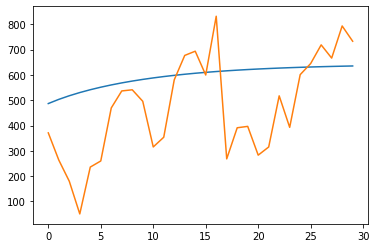

In [72]:
plt.plot([i for i in range(30)],y_pred)
plt.plot([i for i in range(30)],data_1.iloc[-30:,1])

Telah ditunjukan model Var 2 variable belum cukup baik untuk melakukan peramalan